In [10]:
import numpy as np
import os
DATASETS = 'DBLP'
n_label=4

#DATASETS = 'Movie'
#n_label=0

#DATASETS = 'Foursquare'
#n_label=10
MF = 0
if MF:
    name = np.load(os.path.join('EmbeddingData',DATASETS+'new_id.npy'))
    vec = np.load(os.path.join('EmbeddingData',DATASETS+'emb_u.npy'))
else:
    name = np.load(os.path.join('EmbeddingData',DATASETS+'_w2v_id.npy'))
    vec = np.load(os.path.join('EmbeddingData',DATASETS+'_w2v_embedding.npy'))
print(name.shape)
print(vec.shape)

(15649,)
(15649, 128)


In [2]:
def generate_label_Movie():  # multi-hot
    label_dic = {}
    data = open(label_path)
    for i, line in enumerate(data):
        if i > 0:  # ignore 1st line
            line = line.strip().split('\t')
            y = [int(i) for i in line[1:]]
            label_dic['m'+line[0]] = y
        else:
            pass
        # label.append(line)
    return label_dic


def generate_label_DBLP():
    label_dic = {}
    data = open(label_path)
    for i, line in enumerate(data):
        if i > 0:  # ignore 1st line
            line = line.strip().split('\t')
            if line[1] == '1':
                y = 0
            elif line[2] == '1':
                y = 1
            elif line[3] == '1':
                y = 2
            elif line[4] == '1':
                y = 3
            else:
                y = 4
            label_dic[line[0]] = y
        else:
            pass
        # label.append(line)
    return label_dic


def generate_label_Foursquare():
    label_dic = {}
    label_list = []
    data = open(label_path)
    for i, line in enumerate(data):
        if i > 0:  # ignore 1st line
            line = line.strip().split(',')
            if line[1] in label_list:
                label_dic[line[0]] = label_list.index(line[1])
            else:
                label_list.append(line[1])
                label_dic[line[0]] = label_list.index(line[1])
        else:
            pass
        # label.append(line)
    return label_dic

In [4]:
if DATASETS == 'DBLP':
    label_path = os.getcwd()+'/Datasets/DBLP/actor_labels.txt'
    label = generate_label_DBLP()
elif DATASETS == 'Movie':
    label_path = os.getcwd()+'/Datasets/movie/movie_genre_sparse.txt'
    label = generate_label_Movie()
elif DATASETS == 'Foursquare':
    label_path = os.getcwd()+'/Datasets/Foursquare/Foursquare_labels.txt'
    label = generate_label_Foursquare()
else:
    print('Data error')
print('Work in '+label_path)
# print(label)

Work in /mnt_1/weirui_kuang/kwr/just_walks/Datasets/DBLP/actor_labels.txt


In [5]:
# get author vec
data_len = 0
for i in name:
    if i in label:
        data_len += 1
print(data_len)
datamat_x = np.zeros(shape=[data_len, 128])

if DATASETS == 'DBLP':
    datamat_y = np.zeros(data_len)
elif DATASETS == 'Movie':
    datamat_y = np.zeros(shape=[data_len, 5])
elif DATASETS == 'Foursquare':
    datamat_y = np.zeros(data_len)

i = 0
for line, element in enumerate(name):
    # print(element)
    if element in label:
        datamat_x[i] = vec[line]
        datamat_y[i] = label[element]
        i += 1
    else:
        pass

1909


In [6]:
import numpy as np
import sklearn
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import svm

Test_size=0.2

# train test split
x_train, x_test, y_train, y_test = train_test_split(
    datamat_x, datamat_y, test_size=Test_size)

# 分类器使用1对多
if DATASETS == 'DBLP':
    model = LogisticRegression(penalty='l2', dual=False, tol=0.0001,
                               C=1.0, fit_intercept=True, intercept_scaling=1,
                               class_weight=None, random_state=None, solver='liblinear',
                               max_iter=1000, multi_class='ovr',
                               verbose=0, warm_start=False, n_jobs=-1)
    clf = model.fit(x_train, y_train)

elif DATASETS == 'Movie':
    LR = LogisticRegression(penalty='l2', dual=False, tol=0.0001,
                            C=1.0, fit_intercept=True, intercept_scaling=1,
                            class_weight=None, random_state=None, solver='liblinear',
                            max_iter=1000, multi_class='ovr',
                            verbose=0, warm_start=False, n_jobs=-1)
    model = OneVsRestClassifier(LR, n_jobs=-1)
    clf = model.fit(x_train, y_train)

elif DATASETS == 'Foursquare':
    model = LogisticRegression(penalty='l1', dual=False, tol=0.0001,
                               C=1.0, fit_intercept=True, intercept_scaling=1,
                               class_weight=None, random_state=None, solver='liblinear',
                               max_iter=1000, multi_class='ovr',
                               verbose=0, warm_start=False, n_jobs=-1)
    clf = model.fit(x_train, y_train)

mi_f1 = f1_score(y_test, clf.predict(x_test), average='micro')
ma_f1 = f1_score(y_test, clf.predict(x_test), average='macro')
print('Train Acc={:.4f},    Test Acc={:.4f},    Micro-F1={:.4f},    Macro-F1={:.4f}.'
      .format(clf.score(x_train, y_train), clf.score(x_test, y_test), mi_f1, ma_f1))

Train Acc=0.8861,    Test Acc=0.8272,    Micro-F1=0.8272,    Macro-F1=0.8263.


/home/weirui_kuang/anaconda2/envs/kwr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 40.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [11]:
# K-means
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

kmeans = KMeans(n_clusters=n_label, max_iter=300, n_init=10, init='k-means++',
                precompute_distances=True, n_jobs=-1)
kmeans.fit(datamat_x)
y_pr = kmeans.labels_
NMI = normalized_mutual_info_score(datamat_y, y_pr)
print(NMI)

0.29819562406039424


/home/weirui_kuang/anaconda2/envs/kwr/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


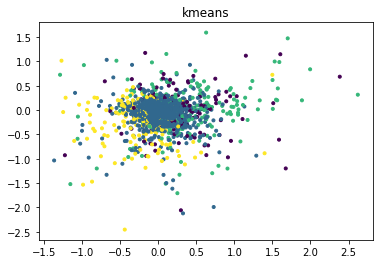

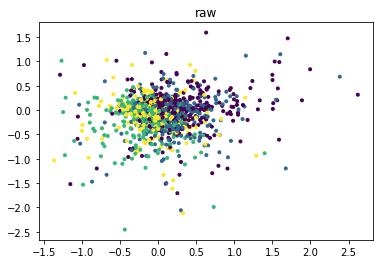

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(datamat_x[:, 0], datamat_x[:, 1], c=y_pr, marker=".")
plt.title('kmeans')
plt.savefig(DATASETS+'keans.jpg', dpi=1080)
plt.show()

plt.scatter(datamat_x[:, 0], datamat_x[:, 1], c=datamat_y,marker=".")
plt.title('raw')
plt.savefig(DATASETS+'raw.jpg',dpi = 1080)
plt.show()